  Lote_ID  Producto Fecha_produccion  Tiempo_ciclo_horas  Temperatura_media  \
0    L001  Vacuna A       2024-12-16                  32               27.2   
1    L002   Suero B       2024-07-07                  33               24.0   
2    L003   Suero B       2024-07-01                  50               27.6   
3    L004  Vacuna A       2024-07-26                  49               21.5   
4    L005  Vacuna A       2024-03-08                  33               24.9   

   Humedad_media Estado_lote Motivo_rechazo  Costo_produccion_USD  \
0             49    Aprobado           None                 11250   
1             53    Aprobado           None                  9842   
2             54    Aprobado           None                 10108   
3             55   Rechazado           None                  9332   
4             46    Aprobado           None                 10273   

  Fecha_vencimiento  
0        2026-12-16  
1        2026-07-07  
2        2026-07-01  
3        2026-07-26  


C:\Users\usuario\AppData\Local\Temp\ipykernel_7692\2609126032.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Estado_lote", y="cantidad", data=aprobados_rechazados, palette="viridis")


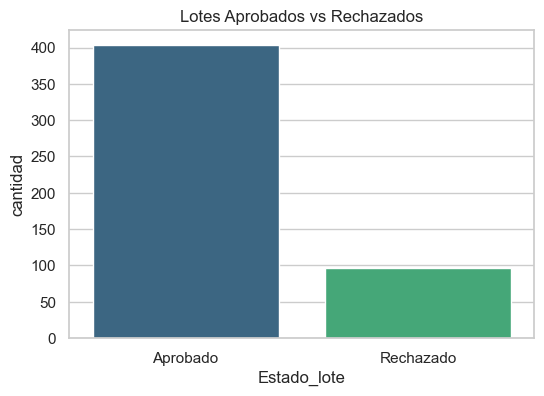

C:\Users\usuario\AppData\Local\Temp\ipykernel_7692\2609126032.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Motivo_rechazo", y="cantidad", data=motivos, palette="magma")


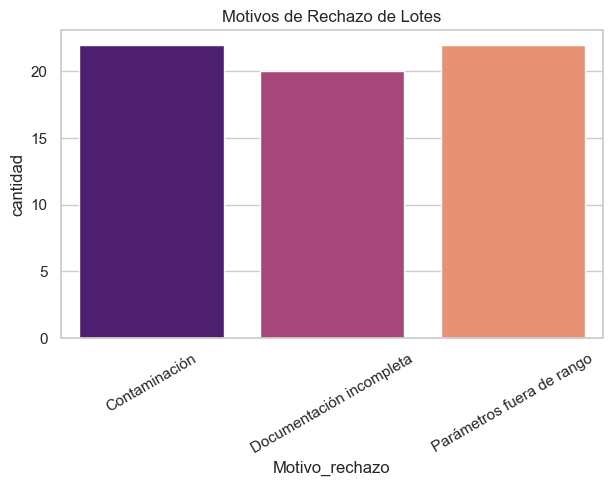

C:\Users\usuario\AppData\Local\Temp\ipykernel_7692\2609126032.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Producto", y="costo_promedio", data=costos, palette="cubehelix")


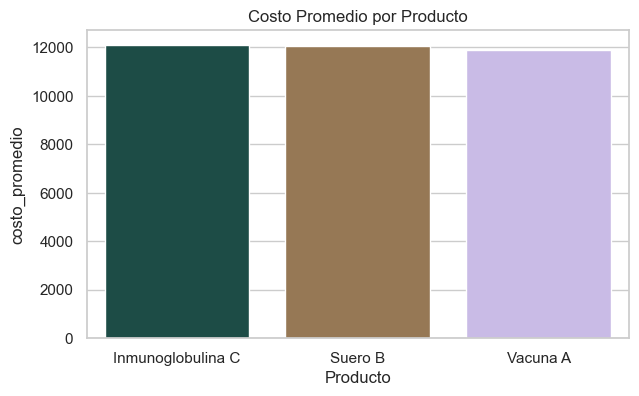

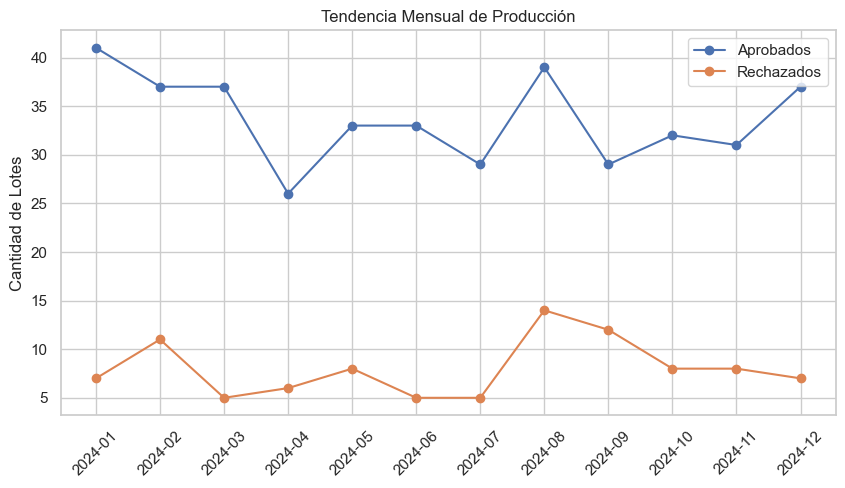

In [3]:
import pandas as pd
import sqlite3
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


productos = ["Vacuna A", "Suero B", "Inmunoglobulina C"]
motivos_rechazo = [None, "Contaminación", "Parámetros fuera de rango", "Documentación incompleta"]

registros = []
start_date = datetime(2024, 1, 1)

for i in range(1, 501):
    lote_id = f"L{i:03d}"
    producto = random.choice(productos)
    fecha_prod = start_date + timedelta(days=random.randint(0, 365))
    tiempo_ciclo = random.randint(30, 50)  # horas
    temperatura = round(random.uniform(20, 28), 1)
    humedad = random.randint(40, 65)
    estado = random.choices(["Aprobado", "Rechazado"], weights=[0.8, 0.2])[0]
    motivo = random.choice(motivos_rechazo) if estado == "Rechazado" else None
    costo = random.randint(9000, 15000)
    fecha_venc = fecha_prod + timedelta(days=730)

    registros.append([lote_id, producto, fecha_prod.strftime("%Y-%m-%d"),
                      tiempo_ciclo, temperatura, humedad,
                      estado, motivo, costo, fecha_venc.strftime("%Y-%m-%d")])

# Crear DataFrame
df = pd.DataFrame(registros, columns=[
    "Lote_ID", "Producto", "Fecha_produccion", "Tiempo_ciclo_horas",
    "Temperatura_media", "Humedad_media", "Estado_lote", "Motivo_rechazo",
    "Costo_produccion_USD", "Fecha_vencimiento"
])

print(df.head())


# 2. Guardar en base SQL (SQLite)

conn = sqlite3.connect("produccion_farma.db")
df.to_sql("Produccion", conn, if_exists="replace", index=False)


# 3. Consultas SQL


# Aprobados vs Rechazados
query1 = """
SELECT Estado_lote, COUNT(*) as cantidad
FROM Produccion
GROUP BY Estado_lote
"""
aprobados_rechazados = pd.read_sql(query1, conn)

# Motivos de rechazo
query2 = """
SELECT Motivo_rechazo, COUNT(*) as cantidad
FROM Produccion
WHERE Estado_lote = 'Rechazado'
GROUP BY Motivo_rechazo
"""
motivos = pd.read_sql(query2, conn)

# Costo promedio por producto
query3 = """
SELECT Producto, AVG(Costo_produccion_USD) as costo_promedio
FROM Produccion
GROUP BY Producto
"""
costos = pd.read_sql(query3, conn)

# Tendencia mensual de lotes aprobados y rechazados
query4 = """
SELECT strftime('%Y-%m', Fecha_produccion) as mes,
       SUM(CASE WHEN Estado_lote = 'Aprobado' THEN 1 ELSE 0 END) as aprobados,
       SUM(CASE WHEN Estado_lote = 'Rechazado' THEN 1 ELSE 0 END) as rechazados
FROM Produccion
GROUP BY mes
ORDER BY mes
"""
tendencia = pd.read_sql(query4, conn)

# ----------------------------
# 4. Visualizaciones en Python
# ----------------------------

sns.set(style="whitegrid")

# Aprobados vs Rechazados
plt.figure(figsize=(6,4))
sns.barplot(x="Estado_lote", y="cantidad", data=aprobados_rechazados, palette="viridis")
plt.title("Lotes Aprobados vs Rechazados")
plt.show()

# Motivos de Rechazo
plt.figure(figsize=(7,4))
sns.barplot(x="Motivo_rechazo", y="cantidad", data=motivos, palette="magma")
plt.title("Motivos de Rechazo de Lotes")
plt.xticks(rotation=30)
plt.show()

# Costo Promedio por Producto
plt.figure(figsize=(7,4))
sns.barplot(x="Producto", y="costo_promedio", data=costos, palette="cubehelix")
plt.title("Costo Promedio por Producto")
plt.show()

# Tendencia mensual de producción
plt.figure(figsize=(10,5))
plt.plot(tendencia["mes"], tendencia["aprobados"], marker="o", label="Aprobados")
plt.plot(tendencia["mes"], tendencia["rechazados"], marker="o", label="Rechazados")
plt.xticks(rotation=45)
plt.title("Tendencia Mensual de Producción")
plt.ylabel("Cantidad de Lotes")
plt.legend()
plt.show()
